In [392]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

from nltk.corpus import stopwords
import spacy
from spacy.pipeline import SentenceSegmenter
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, normalize

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn import metrics

In [2]:
# Utility function for standard text cleaning
def text_cleaner(text):
    
    text = re.sub(r'————', ' @SentBoundary@ ', text )
    
    # Spacy does not recognize: the double dash '--'. 
    text = re.sub(r'--', ' ',text)
    
    # Spacy thinks underscores are a new sentence
    text = re.sub('_', ' ', text)
    
    # Remove text between brackets
    text = re.sub('[\[][\S\s]*?[\]]', "", text)
    
    # Remove beginning of file Project Gutenberg info
    text = re.sub('[\S\s]*(ILLUSTRATED BY .*)', '', text)
    
    # Different format for beginning
    text = re.sub('[\S\s]*(Illustrated by .*)', '', text)
      
    # Remove Project Gutenberg end of file info
    text = re.sub('End of (the )*Project Gutenberg[\S\s]*', '', text, 1)
    
    # Remove Project Gutenberg end of file info
    text = re.sub('_Transcriber\'s note_[\S\s]*', '', text, 1)
    
    # Remove Project Gutenberg end of file info, different format
    text = re.sub('TRANSCRIBER\'S NOTE[\S\s]*', '', text, 1)
    
    # One text ends with the author name
    text = re.sub('=JACK McKENTY=[\S\s]*', '', text, 1)
    
    # Remove story section separators
    text = re.sub('(\s*\*){5}', ' @SentBoundary@ ', text)
    
    # No illustrators in these ones
    text = re.sub('[\S\s]*([Bb][Yy] L. J. STECHER, JR\.)', '', text, 1)
    text = re.sub('[\S\s]*(by Mack Reynolds)', '', text, 1)
    
    # Some texts end with END or THE END
    text = re.sub('\n(THE)* *(END)\n[\S\s]*', '', text, 1)
    
    # Some texts have roman numeral subdivisions, doesn't exceed III
    text = re.sub('\n[I]+\n', '\n\n', text)
    
    text = re.sub('[\n\r]', ' ', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

In [3]:
def split_on_breaks(doc):
    start = 0
    seen_break = False
    for word in doc:
        if seen_break:
            yield doc[start:word.i-1]
            start = word.i
            seen_break = False
        elif word.text == '@SentBoundary@':
            seen_break = True
    if start < len(doc):
        yield doc[start:len(doc)]

sbd = SentenceSegmenter(nlp.vocab, strategy=split_on_breaks)
nlp.add_pipe(sbd, first=True)

#https://github.com/explosion/spaCy/issues/2791
#def get_sentences(text):
#    doc = nlp(text)
#    return (list(doc.sents))
#
#get_sentences("Bob meets Alice. @SentBoundary@ They play together.")

In [4]:
path = 'science_fiction/'
filelist = os.listdir(path)
sentences = []
file_num = 0

for x in filelist:
    if x.endswith('.txt'):
        file_num += 1
        try:
            with open(path + x, 'r') as file:
                text = file.read()
                text = text_cleaner(text)
                text_nlp = nlp(text)
                text_sents = [[sent, x[:-4], x[:-5]] for sent in text_nlp.sents]
                sentences += text_sents
                #print(text_sents)
        except:
            print('Failed Text: {}'.format(x))
            pass

1
second spot
third spot
fourth
2
second spot
third spot
fourth
3
second spot
third spot
fourth
4
second spot
third spot
fourth
5
second spot
third spot
fourth
6
second spot
third spot
fourth
7
second spot
third spot
fourth
8
second spot
third spot
fourth
9
second spot
third spot
fourth
10
second spot
third spot
fourth
11
second spot
third spot
fourth
12
second spot
third spot
fourth
13
second spot
third spot
fourth
14
second spot
third spot
fourth
15
second spot
third spot
fourth
16
second spot
third spot
fourth
17
second spot
third spot
fourth
18
second spot
third spot
fourth
19
second spot
third spot
fourth
20
second spot
third spot
fourth
21
second spot
third spot
fourth
22
second spot
third spot
fourth
23
second spot
third spot
fourth


In [289]:
# Combine the setnences from the two novels into one data frame
df = pd.DataFrame(sentences)
df.columns = ['text_sentences', 'text', 'author']
df.to_csv('scifi.csv')
df.head()

,text_sentences,text,author
0,"(Ed, had, always, been, a, practical, man, ,, ...",dick2,dick
1,"("", Look, at, it, !, "", Loyce, snapped, ., "", ...",dick2,dick
2,"("", Name, ?, "", the, cop, with, the, notebook,...",dick2,dick
3,"(For, a, long, time, Loyce, watched, ,, crouch...",dick2,dick
4,"(Loyce, relaxed, a, little, ., He, studied, th...",dick2,dick


In [290]:
df.shape

(358, 3)

In [291]:
# Add word and punctuation count
df[df['text_sentences'].apply(len)==0]

,text_sentences,text,author
166,(),pohl1,pohl
331,(),reynolds2,reynolds


In [292]:
# Fix two empy rows
df = df.drop([166, 331], axis=0).reset_index()
df.shape

(356, 4)

In [293]:
df.loc[df['author']=='ludwi', 'author'] = 'ludwig' 

In [294]:
# Convert to lemma
both_sents = [' '.join([token.lemma_ for token in sent]) for sent in df['text_sentences']]

# Convert to Part of speech
both_pos = [' '.join([token.pos_ for token in sent]) for sent in df['text_sentences']]

In [295]:
vectorizer = CountVectorizer(max_features=2500, min_df=5, stop_words=STOP_WORDS)
X = vectorizer.fit_transform(both_sents)
columns = list(vectorizer.get_feature_names())
print(columns[0:20])
print(X.toarray())  


['15th', 'abandon', 'ability', 'able', 'aboard', 'abruptly', 'absently', 'absolute', 'absolutely', 'absorb', 'academician', 'academy', 'acceleration', 'accent', 'accept', 'accident', 'accomplish', 'accord', 'account', 'ache']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [296]:
df_bow = pd.DataFrame(X.toarray(), columns=list(vectorizer.get_feature_names()))
df = df.join(df_bow)

In [297]:
df.shape

(356, 2496)

In [298]:
vectorizer_pos = CountVectorizer()
X_pos = vectorizer_pos.fit_transform(both_pos)
columns_pos = list(vectorizer_pos.get_feature_names())
print(columns_pos[0:20])
print(X_pos.toarray())  

['adj', 'adp', 'adv', 'cconj', 'det', 'intj', 'noun', 'num', 'part', 'pron', 'propn', 'punct', 'sym', 'verb']
[[ 36  43  18 ...  48   0  63]
 [ 56  62  64 ... 261   0 175]
 [ 75 103  70 ... 242   0 187]
 ...
 [ 78  92  78 ... 164   0 187]
 [ 85  66  54 ... 157   0 124]
 [ 66  83  57 ... 175   0 142]]


In [299]:
df_pos = pd.DataFrame(X_pos.toarray(), columns=columns_pos)
df = df.join(df_pos, lsuffix='words', rsuffix='pos')

In [300]:
df.head()

,index,text_sentences,text,author,15th,abandon,ability,able,aboard,abruptly,...,det,intj,noun,num,part,pronpos,propn,punct,sym,verb
0,0,"(Ed, had, always, been, a, practical, man, ,, ...",dick2,dick,0,0,0,0,0,0,...,46,0,94,3,10,28,9,48,0,63
1,1,"("", Look, at, it, !, "", Loyce, snapped, ., "", ...",dick2,dick,0,0,0,0,0,0,...,73,6,153,2,24,66,50,261,0,175
2,2,"("", Name, ?, "", the, cop, with, the, notebook,...",dick2,dick,0,0,0,0,0,0,...,120,4,198,5,29,74,43,242,0,187
3,3,"(For, a, long, time, Loyce, watched, ,, crouch...",dick2,dick,0,0,1,0,0,1,...,51,0,86,1,10,25,14,67,0,80
4,4,"(Loyce, relaxed, a, little, ., He, studied, th...",dick2,dick,0,0,0,0,0,0,...,85,1,161,4,22,53,19,155,0,128


In [301]:
# Add word and punctuation count
df['word_count'] = df['text_sentences'].apply(len)-df['punct']

In [302]:
df['all_count'] = df['text_sentences'].apply(len)
df['all_caps'] = [sum([token.is_upper for token in sent]) for sent in df['text_sentences']]

In [303]:
df.head()

,index,text_sentences,text,author,15th,abandon,ability,able,aboard,abruptly,...,num,part,pronpos,propn,punct,sym,verb,word_count,all_count,all_caps
0,0,"(Ed, had, always, been, a, practical, man, ,, ...",dick2,dick,0,0,0,0,0,0,...,3,10,28,9,48,0,63,371,419,11
1,1,"("", Look, at, it, !, "", Loyce, snapped, ., "", ...",dick2,dick,0,0,0,0,0,0,...,2,24,66,50,261,0,175,751,1012,19
2,2,"("", Name, ?, "", the, cop, with, the, notebook,...",dick2,dick,0,0,0,0,0,0,...,5,29,74,43,242,0,187,934,1176,28
3,3,"(For, a, long, time, Loyce, watched, ,, crouch...",dick2,dick,0,0,1,0,0,1,...,1,10,25,14,67,0,80,391,458,3
4,4,"(Loyce, relaxed, a, little, ., He, studied, th...",dick2,dick,0,0,0,0,0,0,...,4,22,53,19,155,0,128,714,869,13


In [361]:
X_train, X_test, y_train, y_test = train_test_split(both_sents, 
                                                    df['author'], 
                                                    test_size=0.3, 
                                                    random_state=0)

vectorizer_tfidf = TfidfVectorizer(max_df=0.75, # drop words that occur in more than this % of paragraphs
                             min_df=5, # only use words that appear at least 5 times
                             #stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
tfidf = vectorizer_tfidf.fit_transform(both_sents)
print("Number of features: %d" % tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf = train_test_split(tfidf, test_size=0.3, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer_tfidf.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[1])
print('Tf_idf vector:', tfidf_bypara[1])

Number of features: 2681
Original sentence: long before -PRON- reach -PRON- destination chandler have reason what -PRON- must be . -PRON- be correct : -PRON- be the island of hawaii . chandler know that the pilot and -PRON- coopt partner be up forward , in the crew compartment , but the door be lock and -PRON- never see -PRON- again . apart from -PRON- -PRON- be the only live person on the plane . the plane be lightly load with cargo of unidentifiable sort . in the rear section , where once tourist - class passenger have eat -PRON- complimentary tray meal and plan -PRON- vacation , the seat have be remove and a thin scatter of crate and box be strap to the floor . in the luxury of the forward section chandler sit , star at the water and drowse . -PRON- seem to be always sleepy . perhaps -PRON- be the consequence of -PRON- exertion ; more likely -PRON- be a psychological phenomenon . -PRON- be beyond worry . -PRON- have reach that point in emotional fatigue when the sudden rattle of can

In [362]:
df_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(terms))

In [363]:
df_tfidf.head()

,15th,abandon,ability,able,aboard,about,above,abruptly,absently,absolute,...,yell,yellow,yes,yesterday,yet,york,young,youth,zone,zoroaster
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.029705,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.073945,0.000000,0.000000,0.0,...,0.0,0.031016,0.0,0.0,0.021093,0.0,0.00000,0.0,0.000000,0.0
3,0.0,0.0,0.069899,0.0,0.0,0.000000,0.000000,0.059547,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.014368,0.000000,0.000000,0.047601,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.02882,0.0,0.047601,0.0


In [307]:
#Only run join once
#df_tfidf = df_tfidf.join(df_pos, lsuffix='tfidf', rsuffix='pos')
#df_tfidf['all_caps'] = df['all_caps']

In [364]:
df_tfidf.head()

,15th,abandon,ability,able,aboard,about,above,abruptly,absently,absolute,...,yell,yellow,yes,yesterday,yet,york,young,youth,zone,zoroaster
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.029705,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.073945,0.000000,0.000000,0.0,...,0.0,0.031016,0.0,0.0,0.021093,0.0,0.00000,0.0,0.000000,0.0
3,0.0,0.0,0.069899,0.0,0.0,0.000000,0.000000,0.059547,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.014368,0.000000,0.000000,0.047601,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.02882,0.0,0.047601,0.0


In [374]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_tfidf, 
                                                    df['author'], 
                                                    test_size=0.30, 
                                                    random_state=0)

#Our SVD data reducer.  We are going to reduce the feature space.
svd= TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train2)
X_test_lsa = lsa.transform(X_test2)

In [385]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_lsa, quantile=0.02)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_lsa)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 8


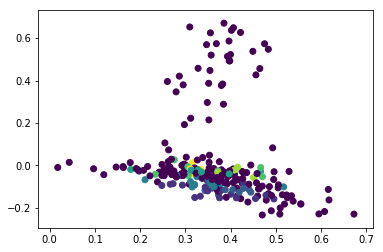

Comparing the assigned categories to the ones in the data:
col_0         0   1   2   3  4  5  6  7
author                                 
dick         41   0   0   0  0  0  0  0
harmon       21   0   0   0  0  0  0  6
leiber        8   0   0   0  0  0  5  0
leinster      0   0   0  14  7  0  0  0
ludwig       10  17   0   0  0  0  0  0
mckenty      10   0   0   0  0  0  0  0
pohl         54   0   0   0  0  0  0  0
quattrocchi  14   0   0   0  0  7  0  0
reynolds      9   0  11   1  0  0  0  0
stetcher     14   0   0   0  0  0  0  0


In [386]:
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:,1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train2,labels))

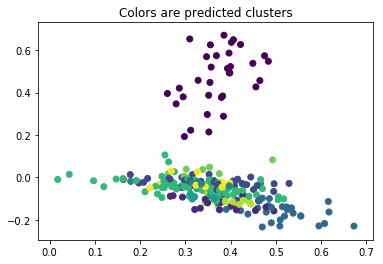

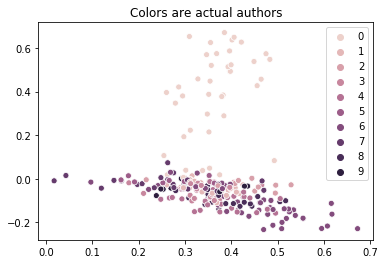

Comparing k-means clusters against the data:
col_0         0   1   2   3  4   5   6  7   8   9
author                                           
dick         33   0   0   0  0   0   1  7   0   0
harmon        0   0   9   0  0   0  18  0   0   0
leiber        0   0  13   0  0   0   0  0   0   0
leinster      0   0   0   0  7  13   1  0   0   0
ludwig        0  17   0   0  0   0  10  0   0   0
mckenty       0   0   6   0  0   0   4  0   0   0
pohl          0   0   3  31  0   0   2  0   0  18
quattrocchi   0   0   6   0  0   0  15  0   0   0
reynolds      0   0   0   0  0   0  10  0  11   0
stetcher      0   0   6   0  0   0   8  0   0   0
Adjusted Rand Index: 0.39
Silhouette Score: 0.13


In [406]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=10).fit_predict(X_train_lsa)

# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=y_pred)
plt.title('Colors are predicted clusters')
plt.show()

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train2)

sns.scatterplot(X_train_lsa[:, 0], X_train_lsa[:, 1], hue=y_train_enc, legend='full')
plt.title('Colors are actual authors')
plt.show()
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train2, y_pred))
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train2, 
                                                                       y_pred)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_lsa, 
                                                                y_pred, 
                                                                metric='euclidean')))


# Part of Speech clustering

In [313]:
df_pos.head()

,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,sym,verb
0,36,43,18,21,46,0,94,3,10,28,9,48,0,63
1,56,62,64,20,73,6,153,2,24,66,50,261,0,175
2,75,103,70,26,120,4,198,5,29,74,43,242,0,187
3,26,55,24,19,51,0,86,1,10,25,14,67,0,80
4,89,84,42,26,85,1,161,4,22,53,19,155,0,128


In [335]:
df_pos['all_caps'] = df['all_caps']

## Means Shift

In [345]:
#Normalize POS data along feature axis to make up for shorter and longer passages
norm = Normalizer(norm='l2')
Xpos_norm = norm.fit_transform(df_pos)

X_train3, X_test3, y_train3, y_test3 = train_test_split(Xpos_norm, 
                                                    df['author'], 
                                                    test_size=0.25, 
                                                    random_state=0)

y_train_text, y_test_text = train_test_split(df['text'], test_size=0.3, random_state=0)

In [346]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train3, quantile=0.2)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train3)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 4


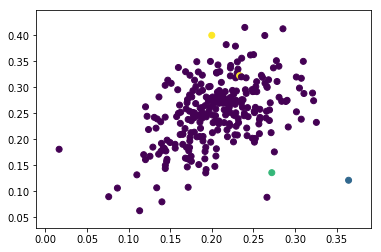

Comparing the assigned categories to the ones in the data:
col_0         0  1  2  3
author                  
dick         43  0  0  0
harmon       29  0  0  0
leiber       14  0  0  0
leinster     24  0  0  0
ludwig       28  0  0  0
mckenty      10  0  0  1
pohl         59  0  0  0
quattrocchi  19  1  1  1
reynolds     22  0  0  0
stetcher     15  0  0  0
Adjusted Rand Index: 0.00


In [347]:
plt.scatter(X_train3[:, 0], X_train3[:,1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train3,labels))
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train3, labels)))

## KMeans

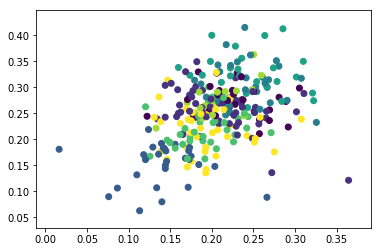

Comparing k-means clusters against the data:
col_0        0   1   2  3  4   5  6   7
author                                 
dick         8   1  14  0  3   2  0  15
harmon       1   5   2  5  1   9  4   2
leiber       0   0   0  7  0   1  6   0
leinster     2   7   0  4  5   3  3   0
ludwig       2   5   6  1  2   2  1   9
mckenty      2   4   0  1  3   0  0   1
pohl         9  18   2  9  5  14  1   1
quattrocchi  5   6   6  0  3   0  1   1
reynolds     3   5   0  0  4   0  0  10
stetcher     0   5   1  5  0   3  1   0
Adjusted Rand Index: 0.08
Silhoutte Score: 0.14


In [356]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=8).fit_predict(X_train3)

# Plot the solution.
plt.scatter(X_train3[:, 0], X_train3[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train3, y_pred))
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train3, 
                                                                       y_pred)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train3, 
                                                                y_pred, 
                                                                metric='euclidean')))


## Spectral

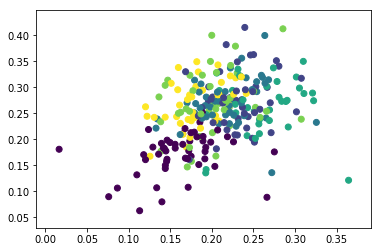

Comparing the assigned categories to the ones in the data:
col_0         0   1   2  3   4   5
author                            
dick         21   0   0  9   3  10
harmon        4  10   6  0   1   8
leiber        0   5   9  0   0   0
leinster      2   2  13  5   1   1
ludwig        5   4   2  5  12   0
mckenty       1   0   2  2   3   3
pohl         11  11  12  5   7  13
quattrocchi   5   1   3  4   2   7
reynolds      1   0   1  6  14   0
stetcher      1  13   0  0   0   1
Adjusted Rand Index: 0.09
Silhouette Score: 0.08


In [358]:
# We know we're looking for three clusters.
n_clusters=6

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train3)

#Predicted clusters.
predict=sc.fit_predict(X_train3)

#Graph results.
plt.scatter(X_train3[:, 0], X_train3[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train3,predict))
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train3, 
                                                                       predict)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train3, 
                                                                predict, 
                                                                metric='euclidean')))


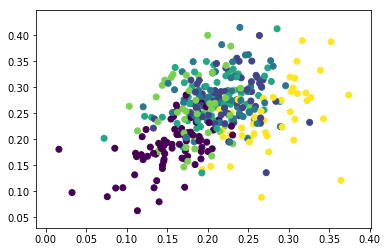

Comparing the assigned categories to the ones in the data:
col_0         0   1   2   3   4   5
author                             
dick         25   0   1  15   3  10
harmon        7   9  16   4   1   6
leiber        0  11   8   0   0   0
leinster      4  14   1   4   1   3
ludwig       10   1   3   5  11  10
mckenty       1   3   0   7   6   0
pohl         22  17   6  17   9   6
quattrocchi  10   5   0   8   4   7
reynolds      0   3   1   1  15   6
stetcher      2   0  16   1   0   0
Adjusted Rand Index: 0.08
Silhouette Score: 0.09


In [357]:
#Predicted clusters.
predict = sc.fit_predict(Xpos_norm)

#Graph results.
plt.scatter(Xpos_norm[:, 0], Xpos_norm[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(df['author'],predict))
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(df['author'], 
                                                                       predict)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(Xpos_norm, 
                                                                predict, 
                                                                metric='euclidean')))


,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,sym,verb,all_caps
0,36,43,18,21,46,0,94,3,10,28,9,48,0,63,11
1,56,62,64,20,73,6,153,2,24,66,50,261,0,175,19
2,75,103,70,26,120,4,198,5,29,74,43,242,0,187,28
3,26,55,24,19,51,0,86,1,10,25,14,67,0,80,3
4,89,84,42,26,85,1,161,4,22,53,19,155,0,128,13
5,83,101,72,32,96,1,183,2,35,121,49,291,0,236,22
6,18,31,20,15,38,0,61,2,12,41,12,79,0,86,12
7,35,52,50,11,80,3,103,5,20,81,43,207,0,147,17
8,27,25,15,9,30,0,55,0,9,22,7,48,0,50,0
9,38,34,22,7,28,0,63,0,9,28,14,78,0,83,2
